# Analyse fréquentielle intégratrice

## Activité de transfert - juin 2022

préparée par :
- Duy Anh Alexandre
- Gabriel Gobeil
- Jonathan Jalbert

## Partie 1 : Analyse fréquentielle classique

Le premier objectif de cette partie consiste à présenter les fonctionnalités de la libraire [*Extremes.jl*](https://github.com/jojal5/Extremes.jl) en Julia pour l'analyse fréquentielle des débits maxima annuels de la rivière Chaudière. 

En particulier, les éléments suivants seront couvert :
- Estimation des paramètres de la loi GEV avec la méthode du maximum de la vraisemblance et la méthode bayésienne.
- Modélisation de la non-stationnarité avec plusieurs modèles possibles.
- Comparaison de modèles.
- Validation des modèles.
- Estimation des niveaux de retour.
- Calcul des intervalles de confiance et de crédibilité sur les paramètres et les niveaux de retour.

Le deuxième objectif consiste à présenter la manipulation des données en Julia. Plus spécifiquement à :
- Charger les données directement d'un url ou d'un fichier CSV.
- Manipuler les [DataFrames](https://dataframes.juliadata.org/stable/), un type très puissant pour la manipulation des données.
- Illustrer les données à l'aide de la librairie [Gadfly](http://gadflyjl.org/stable/).


####  Table des matières
1. [Chargement des librairies et des fonctions utiles](#preparation)
2. [Chargement des données](#data)
    1. [Chargement des débits observés](#data_loading)
    2. [Chargement des variables explicatives](#covariable)
    3. [Affichage des données chargées](#data_viz)
3. [Traitement des données](#traitement)
    1. [Extraction des maxima annuels des débits journaliers](#extraction)
    2. [Jumelage avec la concentration équivalente de CO₂](#jumelage_co2)
    3. [Affichage des données traitées](#affichage_données_traitées)
4. [Modélisation classique des maxima annuels](#modelisation)
    1. [Modèle stationnaire](#mstat)
    2. [Modèles non stationnaires](#mnstat)
5. [Modélisation bayésienne des maxima annuels](#bayes)
    1. [Estimation des paramètres](#param_estimation)
    2. [Évaluation de la qualité d'ajustement du modèle](#qqplots)
    2. [Estimation des niveaux de retour](#returnlevel)

---
# 1. Chargement des librairies et des fonctions utiles <a name="preparation"></a>

In [1]:
# Chargement des librairies
using CSV, DataFrames, Dates
using Distributions, Extremes, LinearAlgebra, Mamba, Random, Statistics
using Gadfly
using ProgressMeter, StatsBase

# Chargement des fonctions utiles (fonctions maisons)
include("1-utils.jl");

---
# 2. Chargement des données <a name="data"></a>

## 2.1 Chargement des débits observés <a name="data_loading"></a>

#### Description des données de la rivière Chaudière (023402)

Ministère de l'Environnement et de la Lutte contre les changements climatique   
Données validées jusqu'au 2021-09-30, préliminaires par la suite   
Station: 023402          
Chaudière - au pont-route 218 à Saint-Lambert-de-Lauzon                                                           

Bassin versant: 5820 km²       
Régime: Influencé journellement                           
Coordonnées: (NAD83) 46° 35' 13" // -71° 12' 49"

#### Chargement des données directement à partir du site web du MELCC

On charge les données directement du site web MELCC avec la fonction `get_discharge_from_txt(data_url)` où `data_url` est l'adresse où les données se trouvent. Les données sont chargées dans un [DataFrame](https://dataframes.juliadata.org/stable/).


In [2]:
# Adresse des données de la rivière Chaudière
data_url = "https://www.cehq.gouv.qc.ca/depot/historique_donnees/fichier/023402_Q.txt"

# Chargement des données dans un DataFrame
discharge = get_discharge_from_txt(data_url)

# Affichage des 5 premières lignes du DataFrame
first(discharge, 5) 

5×4 DataFrame
 Row │ Station  Date        Débit    Remarque 
     │ Int64    Date        Float64  String   
─────┼────────────────────────────────────────
   1 │   23402  1915-02-27    538.0  MC
   2 │   23402  1915-02-28    377.0  MC
   3 │   23402  1915-03-01    269.0  MC
   4 │   23402  1915-03-02    345.0  MC
   5 │   23402  1915-03-03    269.0  MC

<div class="alert alert-block alert-info">
<b>Note :</b> La fonction <code>first(df, n)</code> permet d'afficher les <code>n</code> premières lignes du DataFrame <code>df</code> et <code>last(df, n)</code> permet d'afficher les <code>n</code> dernières lignes. 
</div>

## 2.2 Chargement des variables explicatives <a name="covariable"></a>

La concentration annuelle équivalente de CO₂ dans l'atmosphère sera utilisée comme variable expliquant la non-stationnarité.

In [3]:
# Chargement des données
CO2 = CSV.read("../0-Data/0-RCP/RCPdata.csv", DataFrame)  

# Sélection du scénario RCP8.5 (En période historique, le choix du scénario n'a pas d'impact)
select!(CO2, :Year, :RCP85)

# Modifier les noms des colonnes du DataFrame contenant les données
rename!(CO2, :Year => :Année, :RCP85 => :CO2)

# Affichage des 5 premières lignes
first(CO2, 5)

5×2 DataFrame
 Row │ Année  CO2     
     │ Int64  Float64 
─────┼────────────────
   1 │  1765  277.015
   2 │  1766  277.839
   3 │  1767  278.694
   4 │  1768  278.748
   5 │  1769  278.796

<div class="alert alert-block alert-info">   
<b>Note :</b> 
    On peut accéder à une colonne d'un DataFrame en spécifiant son identifiant de type <code>Symbol</code> qui s'écrit avec le <code>:</code>, p. ex., <code>:Année</code> ou avec le constructeur <code>Symbol()</code>, p. ex., <code>Symbol("Année")</code>, qui est notamment utile lorsque l'identifiant est en deux mots.
</div>

## 2.3 Affichage des données chargées <a name="data_viz"></a>

La librairie [Gadfly](http://gadflyjl.org/stable/) permet de tracer *facilement* les données lorsqu'elles sont stockées dans un DataFrame. La fonction `plot()` permet de créer les graphiques en utilisant directement les noms des colonnes du DataFrame. 

<div class="alert alert-block alert-info">
<b>Note :</b> Il existe différentes librairies pour tracer des graphiques en Julia (p. ex., <i>Plots.jl</i>, <i>Gadfly.jl</i>, <i>VegaLite.jl</i>, etc...) pour tous les goûts et besoins. Ici, on utilise <i>Gadfly.jl</i>, une librairie assez élégante qui est basée sur <i>The Grammar of Graphics</i> : <a href="https://link.springer.com/book/10.1007/0-387-28695-0">https://link.springer.com/book/10.1007/0-387-28695-0</a>.
</div>

#### Affichage des débits

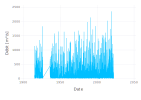

In [4]:
plot(discharge, x=:Date, y=:Débit, Geom.line,
    Guide.ylabel("Débit [m³/s]"))

#### Affichage de la concentration équivalente de CO₂

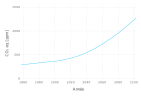

In [5]:
plot(CO2, x=:Année, y=:CO2, Geom.line,
    Coord.cartesian(xmin=1960, xmax=2100, ymin=0, ymax=1500),
    Guide.ylabel("CO₂ eq. [ppm]"))

---
# 3. Traitement des données <a name="traitement"></a>

## 3.1 Extraction des maxima annuels des débits journaliers <a name="extraction"></a>

À partir des données journalières de débit, il est possible d'obtenir les maxima annuels grâce aux fonctions `groupby()` et `combine()` définies pour les DataFrames. 

Comme on cherche à grouper les données par année, on va d'abord faire l'**ajout d'une colonne** pour les années à partir de la colonne des dates.

In [6]:
# Ajout de la variable Année au DataFrame
discharge[:, :Année] = year.(discharge[!, :Date])

# Affichage des 5 premières lignes
first(discharge, 5)

5×5 DataFrame
 Row │ Station  Date        Débit    Remarque  Année 
     │ Int64    Date        Float64  String    Int64 
─────┼───────────────────────────────────────────────
   1 │   23402  1915-02-27    538.0  MC         1915
   2 │   23402  1915-02-28    377.0  MC         1915
   3 │   23402  1915-03-01    269.0  MC         1915
   4 │   23402  1915-03-02    345.0  MC         1915
   5 │   23402  1915-03-03    269.0  MC         1915

<div class="alert alert-block alert-info"> 
<b>Note :</b> En Julia, le <code>.</code> permet de « vectoriser » une fonction sur un vecteur. Par exemple, la fonction <code>year()</code> permet de récupérer l'année d'une variable de type <code>Date</code>. Ainsi, avec <code>year.()</code>, on récupère toutes les années du vecteur de dates.
</div>

In [7]:
# Extraction des maxima annuels
df = combine(groupby(discharge, :Année), :Débit => maximum => :Maximum)

# Affichage des 5 premières lignes
first(df,5)

5×2 DataFrame
 Row │ Année  Maximum 
     │ Int64  Float64 
─────┼────────────────
   1 │  1915   1140.0
   2 │  1916   1010.0
   3 │  1917   1150.0
   4 │  1918    974.0
   5 │  1919   1080.0

## 3.2 Jumelage avec la concentration équivalente de CO₂  <a name="jumelage_co2"></a>

In [8]:
# Jonction des DataFrames
data = rightjoin(df, CO2, on=:Année)

# Retirer les lignes avec valeurs manquantes
dropmissing!(data, :Maximum)

# Changer l'ordre d'affichage des colonnes
select!(data, :Année, :CO2, :Maximum)

# Affichage des 5 premières lignes
first(data,5)

5×3 DataFrame
 Row │ Année  CO2      Maximum 
     │ Int64  Float64  Float64 
─────┼─────────────────────────
   1 │  1915  291.784   1140.0
   2 │  1916  292.238   1010.0
   3 │  1917  292.544   1150.0
   4 │  1918  292.992    974.0
   5 │  1919  293.813   1080.0

## 3.3 Affichage des données traitées <a name="affichage_données_traitées"></a>

#### Affichage des maxima annuels en fonction du temps

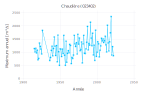

In [9]:
plot(data, x=:Année, y=:Maximum, Geom.line, Geom.point,
    Guide.title("Chaudière (023402)"),
    Guide.xlabel("Année"),
    Guide.ylabel("Maximum annuel [m³/s]"))

#### Affichage des maxima annuels en fonction du CO₂

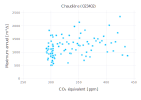

In [10]:
plot(data, x=:CO2, y=:Maximum, 
    Geom.point,  
    Guide.title("Chaudière (023402)"),
    Guide.xlabel("CO₂ équivalent [ppm]"),
    Guide.ylabel("Maximum annuel [m³/s]"))

---
# 4. Modélisation classique des maxima annuels <a name="modelisation"></a>

En théorie des valeurs extrêmes, le théorème fondamental stipule que la loi GEV approxime bien la loi du maximum à condition que la taille de bloc soit grande.

Les paramètres de la loi GEV modélisant les débits maximals annuels seront estimés par la méthode du maximum de la vraisemblance avec la librairie [Extremes.jl](https://github.com/jojal5/Extremes.jl). 

## 4.1 Modèle stationnaire <a name="mstat"></a>

Le modèle `fm₁` est le modèle stationnaire qui suppose que chacun des maxima annuels est distribué selon la loi GEV.

### 4.1.1 Estimation des paramètres de la loi GEV

L'estimation s'effectue en utilisant la fonction [`gevfit()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.gevfit).

In [11]:
fm₁ = gevfit(data, :Maximum)

MaximumLikelihoodEVA
model :
	BlockMaxima
	data :		Vector{Float64}[99]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[1041.4803684990115, 5.768673644437738, -0.11902767624980434]


Les résulats à l'intérieur de la variable `fm` sont contenus dans la structure `MaximumLikelihoodEVA`.

On peut accéder aux estimations des paramètres de la loi GEV de la façon suivante : 

In [12]:
fm₁.θ̂

3-element Vector{Float64}:
 1041.4803684990115
    5.768673644437738
   -0.11902767624980434

<div class="alert alert-block alert-info"> 
<b>Note :</b> <code>Extremes.jl</code> retourne par défaut l'estimation du log du paramètre d'échelle de la loi GEV : ϕ = log σ. 
</div>

Un fois le modèle ajusté, il est possible de calculer les intervalles de confiance sur les estimations des paramètres avec la fonction [`cint()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.cint) : 

In [13]:
cint(fm₁)

3-element Vector{Vector{Float64}}:
 [971.4406543054092, 1111.5200826926139]
 [5.61512737275234, 5.922219916123135]
 [-0.24678942106298274, 0.008734068563374053]

### 4.1.2. Figures diagnostiques

Il est également possible d'évaluer la qualité du modèle ajusté avec la fonction [`diagnosticplots()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.diagnosticplots-Tuple{fittedEVA}) :

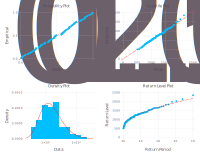

In [14]:
set_default_plot_size(20cm, 16cm)
diagnosticplots(fm₁)

###  4.1.3. Estimation des niveaux de retour

L'estimation du niveau de retour peut être obtenue à l'aide de la fonction [`returnlevel()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.returnlevel-Tuple{BayesianEVA{BlockMaxima},%20Real}). Par exemple, le niveau qui a un probabibilité d'être dépassé en moyenne une fois au 100 ans peut être estimé avec la commande suivante :

In [15]:
r = returnlevel(fm₁, 100)

ReturnLevel
returnperiod :	100
value :		Vector{Float64}[1]


In [16]:
# On accède aux valeurs de la façon suivante :
r.value

1-element Vector{Float64}:
 2175.4170995844415

Un intervalle de confiance sur le niveau de retour peut être obtenu de la fonction [`cint()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.cint) :

In [17]:
cint(r)

1-element Vector{Vector{Real}}:
 [1901.8994082956606, 2448.9347908732225]

## 4.2 Modèles non stationnaires <a name="mnstat"></a>

Dans cette section, les modèles statistiques suivants seront ajustés sur la maxima annuels :
- `fm₂`: Le paramètre de localisation de la loi GEV dépend de l'année.
- `fm₃`: Le paramètre de localisation ainsi que le logarithme du paramètre d'échelle de la loi GEV dépend de l'année.
- `fm₄`: Le paramètre de localisation de la loi GEV dépend de la concentration équivalente de CO₂ dans l'atmosphère.

### 4.2.1 Estimation des paramètres

L'estimation des paramètres du modèle non stationnaire se fait aussi avec la fonction `gevfit()` en spécifiant les variables explicatives pour le paramètre de localisation et le log du paramètre d'échelle.

In [18]:
# La non-stationnatrité est intégrée seulement dans le paramètre de localisation
fm₂ = gevfit(data, :Maximum, locationcovid = [:Année])

MaximumLikelihoodEVA
model :
	BlockMaxima
	data :		Vector{Float64}[99]
	location :	μ ~ 1 + Année
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[-5627.542519256639, 3.3877628170376757, 5.739156167634225, -0.14790668121204079]


Les intervalles de confiances sur les paramètres peuvent être obtenus avec [`cint()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.cint)

In [19]:
cint(fm₂)

4-element Vector{Vector{Float64}}:
 [-9956.331993632617, -1298.753044880661]
 [1.1904619177634164, 5.585063716311935]
 [5.58487240718862, 5.89343992807983]
 [-0.28074926148855117, -0.015064100935530428]

In [20]:
# La non-stationnatrité est intégrée dans le paramètre de localisation et le log du paramètre d'échelle
fm₃ = gevfit(data, :Maximum, locationcovid = [:Année], logscalecovid = [:Année])

MaximumLikelihoodEVA
model :
	BlockMaxima
	data :		Vector{Float64}[99]
	location :	μ ~ 1 + Année
	logscale :	ϕ ~ 1 + Année
	shape :		ξ ~ 1

θ̂  :	[-5162.083870013492, 3.153022981567117, -0.4697729213045134, 0.003149354264464872, -0.16579734126694454]


In [21]:
# On peut également utiliser la concentration de CO2 comme variable explicative.
fm₄ = gevfit(data, :Maximum, locationcovid = [:CO2])

MaximumLikelihoodEVA
model :
	BlockMaxima
	data :		Vector{Float64}[99]
	location :	μ ~ 1 + CO2
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[208.34804301881843, 2.527311924198038, 5.732840500511398, -0.14802083136949823]


### 4.2.2 Comparaison des modèles

Les différents modèles peuvent êtres comparés à l'aide du BIC. Pour l'instant une fonction calculant le BIC n'est pas encore disponible dans `Extremes`. Elle le sera prochainement.

In [22]:
models = [fm₁, fm₂, fm₃, fm₄]

bic = Float64[]

# Calcul du bic pour chacun des modèle
for fm in models
    n = length(fm.model.data.value)
    k = length(fm.θ̂)
    lf = Extremes.loglike(fm)
    push!(bic, lf - k/2*log(n))
end

# Identification du modèle ayant le bic le plus élevé
ind = argmax(bic)

println(string("Le meilleur modèle est le modèle fm",ind,"."))

# fm dénote le meilleur modèle
fm = models[ind]

Le meilleur modèle est le modèle fm4.


MaximumLikelihoodEVA
model :
	BlockMaxima
	data :		Vector{Float64}[99]
	location :	μ ~ 1 + CO2
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[208.34804301881843, 2.527311924198038, 5.732840500511398, -0.14802083136949823]


### 4.2.3 Évaluation de la qualité d'ajustement du modèle

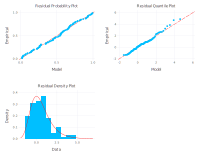

In [23]:
set_default_plot_size(20cm, 16cm)
diagnosticplots(fm)

###  4.2.4. Estimation des niveaux de retour

Les estimations des niveaux de retour à chaque année peuvent être obtenues à l'aide de la fonction [`returnlevel()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.returnlevel-Tuple{BayesianEVA{BlockMaxima},%20Real}).

In [24]:
r = returnlevel(fm, 100)

ReturnLevel
returnperiod :	100
value :		Vector{Float64}[99]


In [25]:
# Intervalles de confiance sur les niveaux de retour effectifs
ci = cint(r)

99-element Vector{Vector{Real}}:
 [1702.589925490337, 2249.788925212577]
 [1704.044155314324, 2250.6334877686027]
 [1705.021389535021, 2251.2023113444147]
 [1706.4518895733836, 2252.0368387987564]
 [1709.0690756983408, 2253.569448307094]
 [1710.84361954923, 2254.612907797924]
 [1712.6890951545552, 2255.7017929753083]
 [1715.0134919661264, 2257.0786950229635]
 [1714.7038400506303, 2256.894914558379]
 [1714.9217327320512, 2257.0242239891045]
 [1716.810357565681, 2258.147295683065]
 [1718.5842258632008, 2259.205836405232]
 [1736.567597030845, 2270.1466909239807]
 ⋮
 [1988.7057959814906, 2486.7687981335926]
 [1995.8943419546868, 2495.566915375626]
 [2003.4282373482201, 2505.0100356479397]
 [2011.1316169313732, 2514.9078166834324]
 [2019.0372881794606, 2525.327734743944]
 [2027.1171346883013, 2536.259794369837]
 [2035.3373008870167, 2547.683412833143]
 [2043.6752257260573, 2559.5904696166513]
 [2052.2096169717015, 2572.120970528006]
 [2061.006452498742, 2585.409757897908]
 [2070.07212792039

#### Affichage des niveaux de retours effectifs et des intervalles de confiance

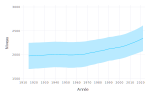

In [26]:
low = first.(ci)
up = last.(ci)

df = DataFrame(Année = data.Année, Niveau = r.value, Low = low, Up = up)

set_default_plot_size(15cm, 10cm)
plot(df, x=:Année, y=:Niveau, Geom.line,
    ymin=:Low, ymax=:Up, Geom.ribbon,
    Coord.cartesian(xmin=1910, xmax=2022),
    Guide.xticks(ticks=1910:10:2020)
)

---
# 5. Modélisation bayésienne des maxima annuels <a name="bayes"></a>

## 5.1 Estimation des paramètres <a name="param_estimation"></a>

L'estimation bayésienne des paramètres s'effectue de la même façon analogue en utilisant la fonction [`gevfitbayes()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.gevfitbayes).

In [27]:
fm₅ = gevfitbayes(data, :Maximum, locationcovid=[:CO2])

Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


BayesianEVA
model :
	BlockMaxima
	data :		Vector{Float64}[99]
	location :	μ ~ 1 + CO2
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

sim :
	Mamba.Chains
	Iterations :		2001:5000
	Thinning interval :	1
	Chains :		1
	Samples per chain :	3000
	Value :			Array{Float64, 3}[3000,4,1]


In [28]:
# Estimation des intervalles de crédibilité bayésien
cint(fm₅)

4-element Vector{Vector{Float64}}:
 [-512.7701033869826, 677.7482345805006]
 [1.113934668373688, 4.701991609955069]
 [5.599243024618279, 5.924702631989332]
 [-0.29828566441378956, -0.010366979623141832]

## 5.2 Évaluation de la qualité d'ajustement du modèle <a name="qqplots"></a>

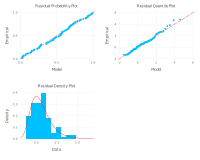

In [29]:
set_default_plot_size(20cm, 16cm)
diagnosticplots(fm₅)

## 5.3 Estimation des niveaux de retour <a name="returnlevel"></a>

Les estimations des niveaux de retour à chaque année peuvent être obtenues à l'aide de la fonction [`returnlevel()`](https://jojal5.github.io/Extremes.jl/stable/functions/#Extremes.returnlevel-Tuple{BayesianEVA{BlockMaxima},%20Real}).

In [30]:
r = returnlevel(fm₅, 100)

ReturnLevel
returnperiod :	100
value :		Matrix{Float64}[297000]


In [31]:
# Intervalles de crédibilité sur les niveaux de retour effectifs
ci = cint(r)

99-element Vector{Vector{Real}}:
 [1753.3372769211837, 2369.0882191031596]
 [1755.109909253605, 2369.962355996586]
 [1756.3020969699526, 2370.550258658457]
 [1759.4131666951234, 2372.575185245838]
 [1762.4042545011598, 2373.291281359696]
 [1764.3720884723411, 2374.5254524637085]
 [1765.820560221673, 2375.176943241764]
 [1768.5385180530968, 2376.5843960916077]
 [1768.1580251480395, 2376.3967639019456]
 [1768.4257577607048, 2376.528790690594]
 [1770.7481208791255, 2377.6740159268797]
 [1772.9322327852703, 2378.601260150588]
 [1785.9552491907452, 2381.793352509406]
 ⋮
 [2034.392323305064, 2593.3004331855136]
 [2041.580417414398, 2603.6490185048624]
 [2050.2634428254732, 2615.1695878483106]
 [2084.049452881037, 2653.2993777857055]
 [2069.937720543797, 2640.0541067506165]
 [2080.4175533740863, 2653.638752967695]
 [2081.649213538002, 2659.7285468182204]
 [2085.003913034587, 2669.158521757783]
 [2118.540424054738, 2709.785279771529]
 [2125.652700734423, 2723.74548637044]
 [2131.515855221315, 

#### Affichage des niveaux de retours effectifs et des intervalles de crédibilité

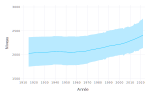

In [32]:
niveau = vec(mean( r.value , dims=1))
low = first.(ci)
up = last.(ci)

df = DataFrame(Année = data.Année, Niveau = niveau, Low = low, Up = up)

set_default_plot_size(15cm, 10cm)
plot(df, x=:Année, y=:Niveau, Geom.line,
    ymin=:Low, ymax=:Up, Geom.ribbon,
    Coord.cartesian(xmin=1910, xmax=2022),
    Guide.xticks(ticks=1910:10:2020)
)